Data:

aisles.csv: 134 aisle names

departments.csv: 21 department names

order_products__*.csv
These files specify which products were purchased in each order. order_products__prior.csv contains previous order contents for all customers. 'reordered' indicates that the customer has a previous order that contains the product. Note that some orders will have no reordered items. You may predict an explicit 'None' value for orders with no reordered items.

orders.csv
Orders for each customer. Order_eval is for test-train-split purposes. 'order_dow' is the day of week.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# plt.style.use('ggplot')


Make a goods dataframe that has the following information for 49688 products:
- product_id	
- product_name	
- aisle_id	
- department_id	
- department	aisle

In [3]:
aisles = pd.read_csv('../data/aisles.csv')

# missing is a purposeful value
departments = pd.read_csv('../data/departments.csv')

products = pd.read_csv('../data/products.csv')

In [4]:
## Merge aisle, department and products into one dataframe
goods = pd.merge(left=pd.merge(left=products, right=departments, how='left'), right=aisles, how='left')

# Replace spaces with '_' and retain '-' in product name and in aisle
goods.product_name = goods.product_name.str.replace(' ', '_').str.lower() 
goods.aisle = goods.aisle.str.replace(' ', '_').str.lower() 
goods.department = goods.department.str.replace(' ', '_').str.lower() 

print(goods.shape)
goods.head()

(49688, 6)


,product_id,product_name,aisle_id,department_id,department,aisle
0,1,chocolate_sandwich_cookies,61,19,snacks,cookies_cakes
1,2,all-seasons_salt,104,13,pantry,spices_seasonings
2,3,robust_golden_unsweetened_oolong_tea,94,7,beverages,tea
3,4,smart_ones_classic_favorites_mini_rigatoni_wit...,38,1,frozen,frozen_meals
4,5,green_chile_anytime_sauce,5,13,pantry,marinades_meat_preparation


In [5]:
orders = pd.read_csv('../data/orders.csv')

Combine train and prior datasets to get 3346083 unique orders with 33819106 items

In [6]:
prior_orders = pd.read_csv('../data/order_products__prior.csv')
orders_train = pd.read_csv('../data/order_products__train.csv')

# Train set is not in prior so we should concatenate together
list_ids = orders_train.order_id.unique()
prior_orders.order_id.isin(list_ids).sum()

all_prior_orders = pd.concat([prior_orders,orders_train])

In [7]:
orders.head()
reorder_df = all_prior_orders.groupby('order_id').reordered.agg(['sum','count'])
reorder_df['percent_reorder']= reorder_df['sum']/ reorder_df['count']*100

In [8]:
# Add a column with number of items and percent items reordered
orders = pd.merge(orders,reorder_df, left_on='order_id', right_index=True)
orders.drop(['sum','eval_set'], inplace=True, axis=1)

In [9]:
orders.rename(columns={'count':'item_count'}, inplace=True)

In [10]:
orders.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,item_count,percent_reorder
0,2539329,1,1,2,8,NaN,5,0.0
1,2398795,1,2,3,7,15.0,6,50.0
2,473747,1,3,3,12,21.0,5,60.0
3,2254736,1,4,4,7,29.0,5,100.0
4,431534,1,5,4,15,28.0,8,62.5


In [37]:
# orders.to_csv('../data/orders_fa.csv')

### Missing Values
- Aisles: 0
- Departments: 0 (labelled 'missing')
- Orders: 6% of observations (206209/3421083), NaN indicates no items are re-ordered
- Products: 0 

In [49]:
# Check null and na values
aisles.isnull().sum()
departments.isnull().sum()
products.isnull().sum()
orders.isnull().sum()

# Calculate %items that are new orders
orders.days_since_prior_order.isnull().sum()/orders.shape[0]*100

6.027594185817766

In [43]:
orders.days_since_prior_order.unique()

array([nan, 15., 21., 29., 28., 19., 20., 14.,  0., 30., 10.,  3.,  8.,
       13., 27.,  6.,  9., 12.,  7., 17., 11., 22.,  4.,  5.,  2., 23.,
       26., 25., 16.,  1., 18., 24.])

### Description:
- 206209 customers
- Orders per customer
    - Average order number:  16.6
    - Median order number:  10.0
    - Max order number:  100
    - Min Order number:  4

In [9]:
orders.user_id.nlargest(1)
df = orders.groupby('user_id').order_id.agg('count')

In [108]:
insta_palette = ['#ff8200', '#43b02a']
color_label = ['orange', 'green']

c = lambda x: insta_palette[color_label.index(x)]


<Figure size 432x288 with 0 Axes>

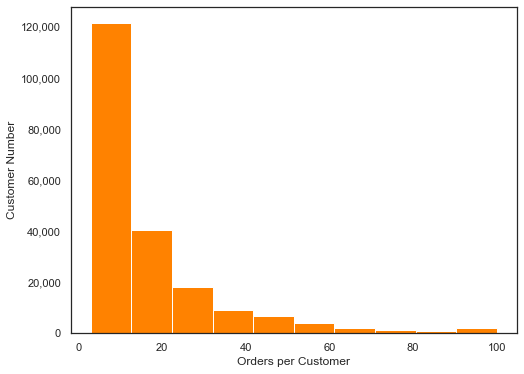

In [109]:
plt.clf()
plt.figure(figsize = (8,6))

g = sns.distplot(df,kde=False, bins=10, color=c('orange'),
                hist_kws={'alpha':1} )
ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
g.set_yticklabels(ylabels)
plt.xlabel('Orders per Customer')
plt.ylabel('Customer Number')
plt.savefig('orders_per_customer.pdf', format='pdf')

In [50]:
# Most customers place 10 orders
print('Average order number: ', np.mean(df))
print('Median order number: ', np.median(df))
print('Max order number: ', max(df))
print('Min order number: ', min(df))


Average order number:  16.226658390273947
Median order number:  10.0
Max order number:  100
Min order number:  3


Busiest Day: 0,  585237
Slowest Day: 4,  417171


<Figure size 432x288 with 0 Axes>

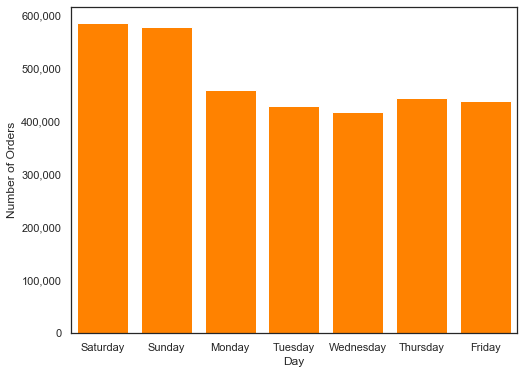

In [120]:
dow = orders.groupby('order_dow').order_id.agg('count')

print('Busiest Day: 0, ', max(dow))
print('Slowest Day: 4, ', min(dow))
plt.clf()


plt.figure(figsize = (8,6))
g= sns.barplot(dow.index, dow, color=c('orange'), saturation=1)
ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
g.set_yticklabels(ylabels)
g.set_xticklabels(['Saturday', 'Sunday', 'Monday', 'Tuesday','Wednesday', 'Thursday', 'Friday'])
plt.xlabel('Day')
plt.ylabel('Number of Orders')
plt.savefig('orders_per_day.pdf', format='pdf')

Top 5 Busiest Hours:  order_hour_of_day
10    288418
11    284728
15    283639
14    283042
13    277999
Name: order_id, dtype: int64
Slowest Hour:  order_hour_of_day
3    5474
4    5527
2    7539
5    9569
Name: order_id, dtype: int64


Text(0, 0.5, 'Number of Orders')

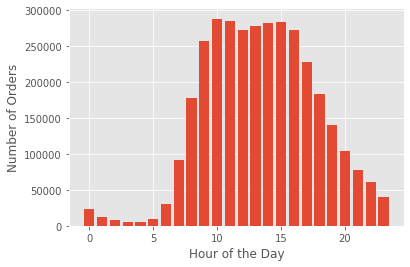

In [90]:
hours = orders.groupby('order_hour_of_day').order_id.agg('count')

print('Top 5 Busiest Hours: ', hours.nlargest(5))
print('Slowest Hour: ', hours.nsmallest(4))

plt.pyplot.bar(hours.index, hours)
plt.pyplot.xlabel('Hour of the Day')
plt.pyplot.ylabel('Number of Orders')

In [79]:
grouped_df = orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

hour_list = np.arange(1,13)
am_pm = [' AM',' PM']
time_labels = [str(i)+j for j in am_pm for i in hour_list]



<Figure size 432x288 with 0 Axes>

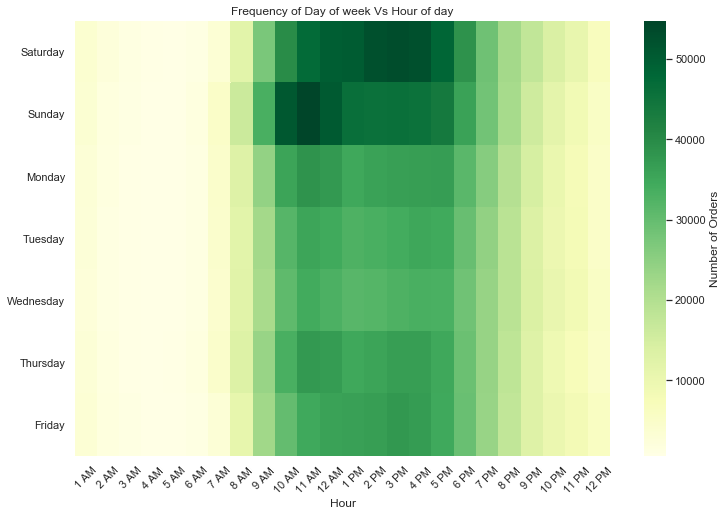

In [101]:
plt.clf()

plt.figure(figsize=(12,8))
chart = sns.heatmap(grouped_df, cmap='YlGn', xticklabels=time_labels, cbar_kws={'label': 'Number of Orders'})
chart.set(ylabel='', xlabel= 'Hour')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

chart.set_yticklabels(['Saturday', 'Sunday', 'Monday', 'Tuesday','Wednesday', 'Thursday', 'Friday'],rotation=0)


plt.title("Frequency of Day of week Vs Hour of day")
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.savefig('orders_by_hour_day_GnYl.pdf', format='pdf')

Text(0, 0.5, 'Number of Orders')

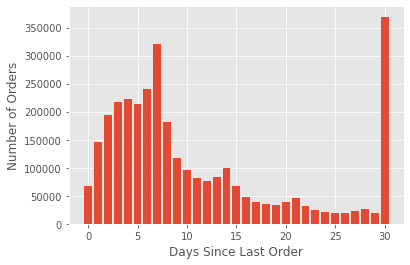

In [91]:
days_since = orders.groupby('days_since_prior_order').order_id.agg('count')

plt.pyplot.bar(days_since.index, days_since)
plt.pyplot.xlabel('Days Since Last Order')
plt.pyplot.ylabel('Number of Orders')

Average item number:  10.10707325550502
Median item number:  8.0
Max item number:  145
Min item number:  1


Text(0, 0.5, 'Frequency')

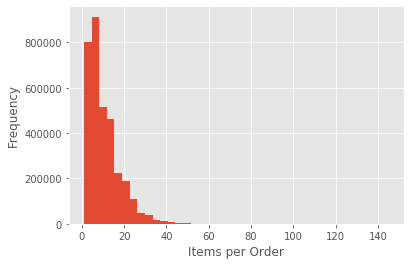

In [87]:
# Items per order
x = all_prior_orders.groupby('order_id').product_id.agg('count')

# Most customers place 10 orders
print('Average item number: ', np.mean(x))
print('Median item number: ', np.median(x))
print('Max item number: ', max(x))
print('Min item number: ', min(x))

plt.pyplot.hist(x, bins =40)
plt.pyplot.xlabel('Items per Order')
plt.pyplot.ylabel('Frequency')

In [122]:
full_prod_orders = pd.merge(all_prior_orders,goods, on = ['product_id','product_id'])

TypeError: object of type 'NoneType' has no len()

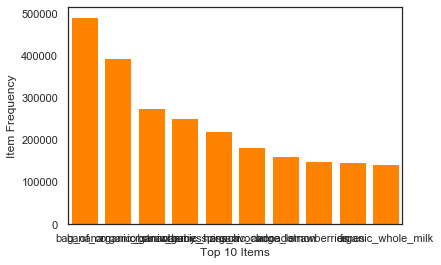

In [124]:
# Find the top 10 most popular items
top10_products = full_prod_orders.groupby('product_id').product_name.agg('count').nlargest(10)
top10_df = pd.merge(top10_products, full_prod_orders, how='left', on=['product_id', 'product_id'])
top10_df = top10_df.loc[:,['product_id', 'product_name_y']]
x = top10_df.groupby('product_name_y', as_index=False).agg('count').sort_values(by='product_id', ascending=False)


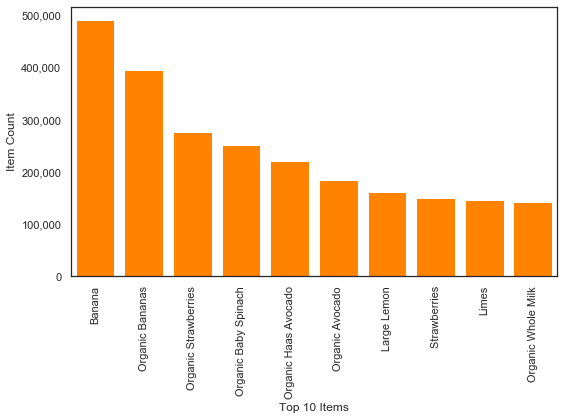

In [140]:
x_names= ['Banana', 'Organic Bananas', 'Organic Strawberries', 'Organic Baby Spinach', 'Organic Haas Avocado', 'Organic Avocado', 'Large Lemon', ' Strawberries', 'Limes', 'Organic Whole Milk']

plt.figure(figsize = (8,6))
g = sns.barplot(x.product_name_y, x.product_id, color=c('orange'), saturation=1)
g.set_xticklabels(x_names, rotation=90)
ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
g.set_yticklabels(ylabels)

plt.xlabel('Top 10 Items')
plt.ylabel('Item Count')
plt.tight_layout()
plt.savefig('popular_items.pdf', format='pdf')

In [141]:
# Find the top 10 most popular departments based on items bought per department
x = full_prod_orders.groupby('department_id').product_name.agg('count').nlargest(10)
top10_df = pd.merge(x, full_prod_orders, how='left', on=['department_id', 'department_id'])
top10_df = top10_df.loc[:,['department_id', 'department']]
y = top10_df.groupby('department', as_index=False).agg('count').sort_values(by='department_id', ascending=False)

x_names_dept = ['Produce', 'Dairy & Eggs', 'Snacks', 'Beverages', 'Frozen', 'Pantry', 'Bakery', 'Canned Goods', 'Deli', 'Dry Goods & Pasta']

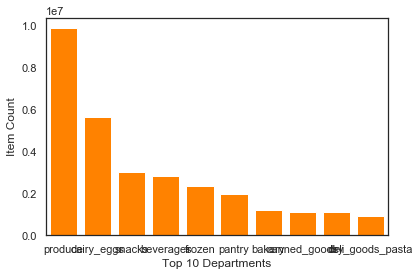

In [142]:
g=sns.barplot(y.department, y.department_id, saturation=1, color=c('orange'))


plt.xlabel('Top 10 Departments')
plt.ylabel('Item Count')
plt.tight_layout()
plt.savefig('popular_dept.pdf', format='pdf')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

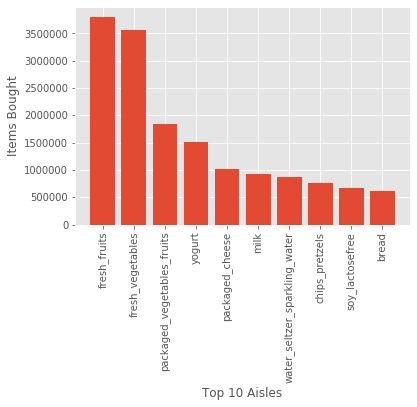

In [88]:
# Find the top 10 most popular aisles based on items bought per aisle
x = full_prod_orders.groupby('aisle_id').product_name.agg('count').nlargest(10)
top10_df = pd.merge(x, full_prod_orders, how='left', on=['aisle_id', 'aisle_id'])
top10_df = top10_df.loc[:,['aisle_id', 'aisle']]
y = top10_df.groupby('aisle', as_index=False).agg('count').sort_values(by='aisle_id', ascending=False)

plt.pyplot.bar(y.aisle, y.aisle_id)
plt.pyplot.xlabel('Top 10 Aisles')
plt.pyplot.ylabel('Items Bought')
plt.pyplot.xticks(rotation=90)

### Conclusions

1. Most customers place 10 orders (median)
    - Maximum is 100 orders 
    - Minimum is 4 orders
2. Orders, on average, contain 10 items
    - Largest order is 145 items
    - Smallest order is 1 item.
2. Day 0-1 (assuming to be Saturday, Sunday) are the days with the most orders
3. Peak ordering time is mid-day 9am-4pm 
4. Most re-orders are placed over a month or one week after the original order
5. Bananas are the most ordered item
    - 9/10 top items are produce
    - 6/10 top items are organic
6. Produce and Dairy/Eggs are the most popular departments (most items bought)
7. Fresh fruits and veggies are the most popular aisles

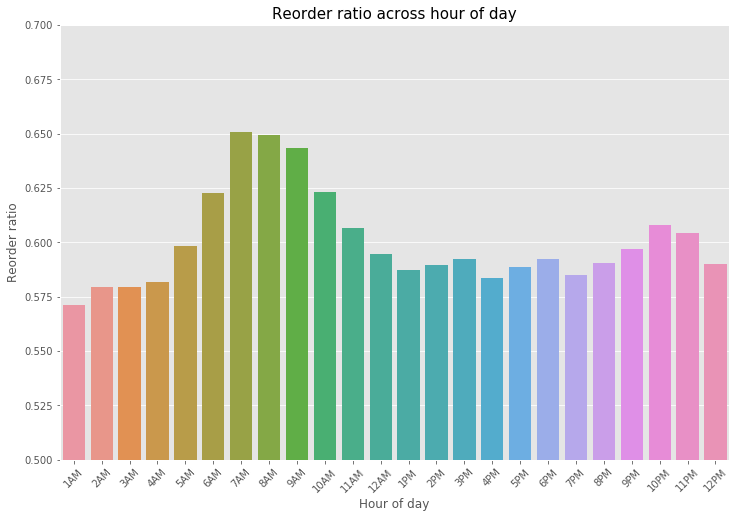

In [43]:
hour_list = np.arange(1,13)
am_pm = ['AM','PM']
time_labels = [str(i)+j for j in am_pm for i in hour_list]

orders_train_df = pd.merge(orders_train, orders, on='order_id', how='left')
grouped_df = orders_train_df.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

plt.pyplot.figure(figsize=(12,8))
chart = sns.barplot(grouped_df['order_hour_of_day'].values, grouped_df['reordered'].values)
plt.pyplot.ylabel('Reorder ratio', fontsize=12)
plt.pyplot.xlabel('Hour of day', fontsize=12)
plt.pyplot.title("Reorder ratio across hour of day", fontsize=15)
chart.set_xticklabels(time_labels, rotation='45')
plt.pyplot.ylim(0.5, 0.7)
plt.pyplot.show()


In [ ]:
grouped_df = orders_train.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

plt.pyplot.figure(figsize=(12,8))
chart = sns.barplot(grouped_df['order_hour_of_day'].values, grouped_df['reordered'].values)
plt.pyplot.ylabel('Reorder ratio', fontsize=12)
plt.pyplot.xlabel('Hour of day', fontsize=12)
plt.pyplot.title("Reorder ratio across hour of day", fontsize=15)
chart.set_xticklabels(time_labels, rotation='45')
plt.pyplot.ylim(0.5, 0.7)
plt.pyplot.show()

In [ ]:
orders_prior = pd.read_csv('../data/'+files[4])

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,chocolate_sandwich_cookies,61,19,snacks,cookies_cakes
1,2,all-seasons_salt,104,13,pantry,spices_seasonings
2,3,robust_golden_unsweetened_oolong_tea,94,7,beverages,tea
3,4,smart_ones_classic_favorites_mini_rigatoni_wit...,38,1,frozen,frozen_meals
4,5,green_chile_anytime_sauce,5,13,pantry,marinades_meat_preparation
